In [559]:
import sympy as sm
from sympy import diff, Symbol
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [560]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [561]:
from sympy.physics.mechanics import dynamicsymbols

In [562]:
m1, m2, l1, l2, g = sm.symbols('m1 m2 l1 l2 g', real =True)
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
g, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'')

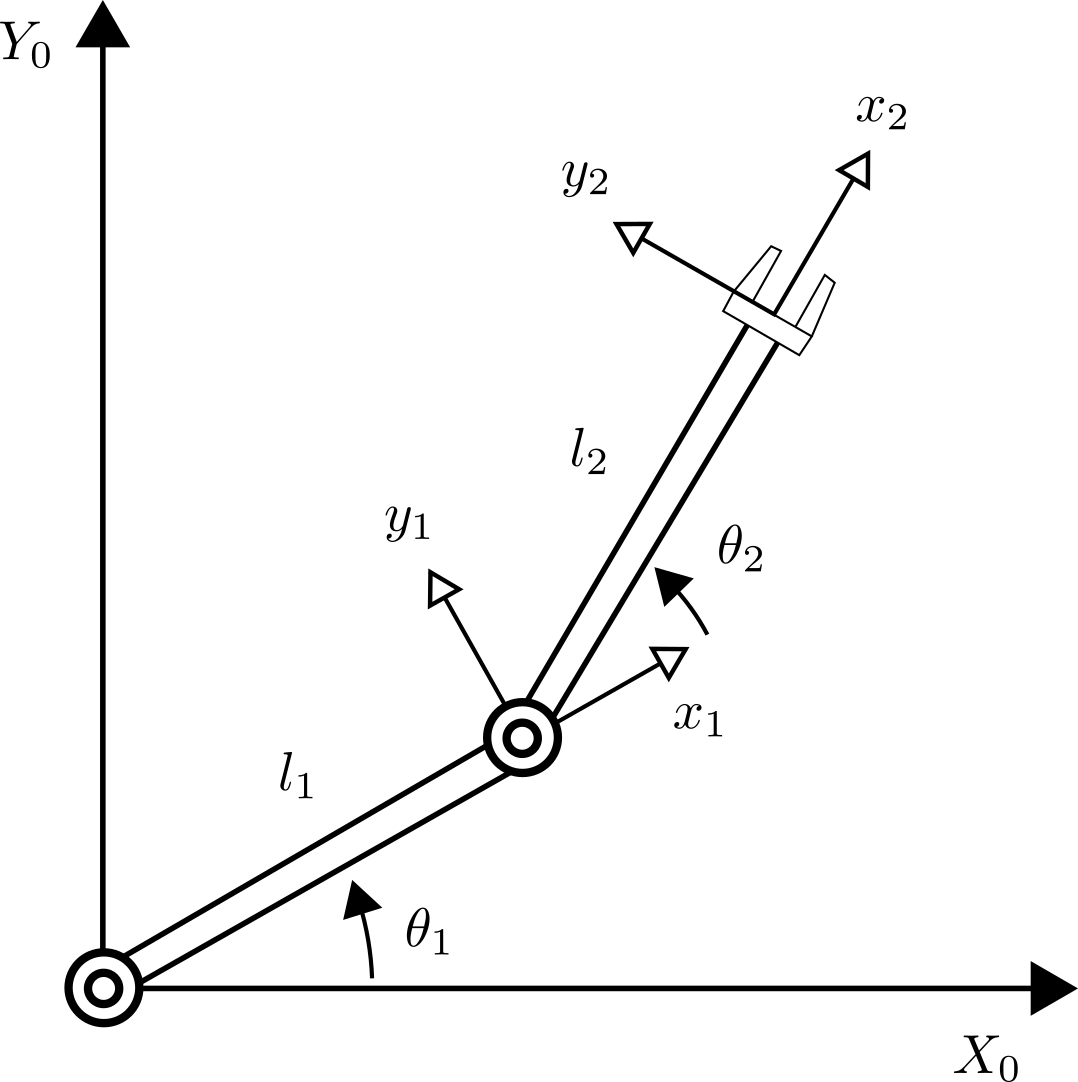

In [563]:
from IPython.display import Image
Image('fig/2rp_new.png', width=300)

In [564]:
x1 = l1*sm.sin(theta1)
y1 = -l1*sm.cos(theta1)
x2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)
y2 = -l1*sm.cos(theta1) - l2*sm.cos(theta2)

x1_dot = sm.diff(x1,Symbol('t'))
x2_dot = sm.diff(x2,Symbol('t'))
y1_dot = sm.diff(y1,Symbol('t'))
y2_dot = sm.diff(y2,Symbol('t'))

x1_dot , x2_dot, y1_dot , y2_dot

(l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2', l1*sin(theta1)*theta1', l1*sin(theta1)*theta1' + l2*sin(theta2)*theta2')

In [565]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [566]:
# potential energy
pe = m1*g*y1
pe += m2*g*y2
sm.expand(pe)

-g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - g*l2*m2*cos(theta2)

In [567]:
# the lagrangian equation
L = ke - pe
Ls = L.subs(g, 9.81)
Ls

l1**2*m1*sin(theta1)**2*theta1'**2/2 + l1**2*m1*cos(theta1)**2*theta1'**2/2 + 9.81*l1*m1*cos(theta1) - 9.81*m2*(-l1*cos(theta1) - l2*cos(theta2)) + m2*(l1*sin(theta1)*theta1' + l2*sin(theta2)*theta2')**2/2 + m2*(l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')**2/2

In [568]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),Symbol('t')) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

1.0*l1**2*m1*theta1'' + 1.0*l1**2*m2*theta1'' + 1.0*l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + 1.0*l1*l2*m2*cos(theta1 - theta2)*theta2'' + 9.81*l1*m1*sin(theta1) + 9.81*l1*m2*sin(theta1)

In [569]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),Symbol('t')) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

-1.0*l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + 1.0*l1*l2*m2*cos(theta1 - theta2)*theta1'' + 1.0*l2**2*m2*theta2'' + 9.81*l2*m2*sin(theta2)

In [570]:
#inertia term
B11 = f1sim.coeff(theta1dd) * theta1dd
B12 = f2sim.coeff(theta1dd) * theta1dd

B21 = f1sim.coeff(theta2dd) * theta2dd
B22 = f2sim.coeff(theta2dd) * theta2dd

B = sm.Matrix([[B11, B21], [B12, B22]])
B

Matrix([
[    (1.0*l1**2*m1 + 1.0*l1**2*m2)*theta1'', 1.0*l1*l2*m2*cos(theta1 - theta2)*theta2''],
[1.0*l1*l2*m2*cos(theta1 - theta2)*theta1'',                      1.0*l2**2*m2*theta2'']])

In [571]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([C11, C12])
C

Matrix([
[ 1.0*l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-1.0*l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [572]:
# gravity term
g1 = f1sim - sm.expand(B11) - sm.expand(B21) - sm.expand(C11)
g2 = f2sim - sm.expand(B12) - sm.expand(B22) - sm.expand(C12)
g = sm.Matrix([g1, g2])
g

Matrix([
[9.81*l1*m1*sin(theta1) + 9.81*l1*m2*sin(theta1)],
[                         9.81*l2*m2*sin(theta2)]])

In [573]:
# dynamic equations
dynamics_sol = sm.solve([f1sim,f2sim],[theta1dd,theta2dd])
theta1dd_solver = dynamics_sol[theta1dd]
theta2dd_solver = dynamics_sol[theta2dd]

In [574]:
theta1dd_func = sm.lambdify([m1, m2, l1, l2, theta1, theta2, theta1d, theta2d], theta1dd_solver)
theta2dd_func = sm.lambdify([m1, m2, l1, l2, theta1, theta2, theta1d, theta2d], theta2dd_solver)
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

In [575]:
# ode func for scipy odeint
def dSdt(S,t, m1, m2, l1, l2):
    thet1, thet1d, thet2, thet2d = S
    return [
        theta1d_func(thet1d),
        theta1dd_func(m1, m2, l1, l2, thet1, thet2, thet1d, thet2),
        theta2d_func(thet2d),
        theta2dd_func(m1, m2, l1, l2, thet1, thet2, thet1d, thet2)
    ]

In [621]:
t = np.linspace(0, 40, 1001)
m1 = 2
m2 = 1
l1 = 2
l2 = 1
ans = odeint(dSdt, y0=[1, 0, 1, 0.2], t=t, args=(m1, m2, l1, l2))

In [622]:
ans.T

array([[ 1.        ,  0.99670331,  0.98684957, ...,  0.87338233,
         0.90112918,  0.92387878],
       [ 0.        , -0.16465623, -0.32765413, ...,  0.75396147,
         0.63225729,  0.50424617],
       [ 1.        ,  1.00797816,  1.01579286, ...,  1.29787409,
         1.2964907 ,  1.28872745],
       [ 0.2       ,  0.19826403,  0.1913915 , ...,  0.05225253,
        -0.11779515, -0.26708827]])

In [623]:
the1 = ans.T[0]
the1d = ans.T[1]
the2 = ans.T[2]
the2d = ans.T[3]

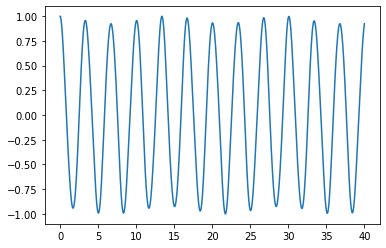

In [624]:
plt.plot(t, the1)

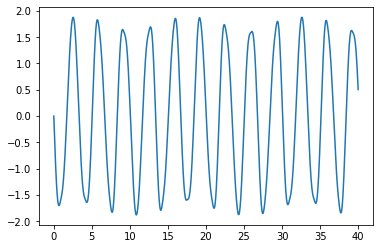

In [625]:
plt.plot(t, the1d)

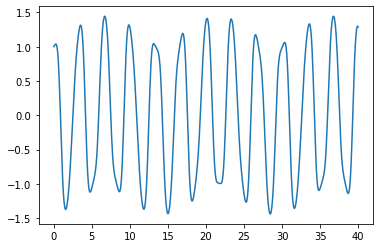

In [626]:
plt.plot(t, the2)

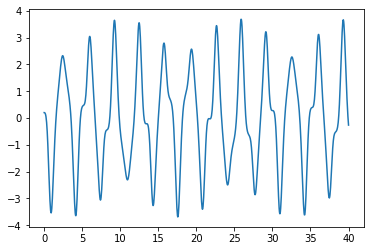

In [627]:
plt.plot(t, the2d)

In [628]:
def get_x1y1x2y2(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
            -L1*np.cos(the1),
            L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2))

x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], ans.T[2], l1, l2)

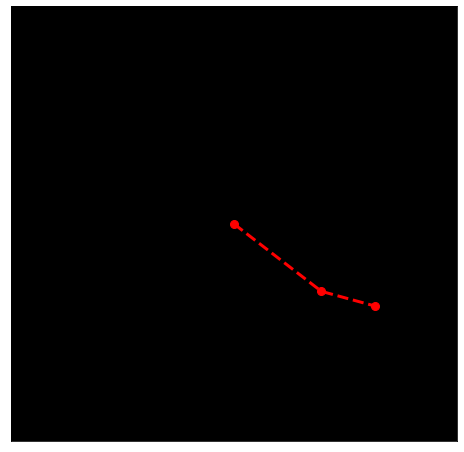

In [629]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)